ℹ️ Info¶¶

* **forked original great work kernels**
    * https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet

* **My upd(2024/11/08)**
    * As a discussion issue for the original kernel.There was a problem that reproducibility was not guaranteed and LB was unstable.
    * Therefore, Seed fixes such as Torch and LGB have been modified to ensure reproducibility.
    * Below is the result of measuring LB with this kernel.
        * [Version1.LB]0.492
        * [Version2.LB]0.492
        * [Version3.LB]0.492




---
---

# Based
- https://www.kaggle.com/code/honganzhu/cmi-piu-competition?scriptVersionId=201912528 Version44 LB0.492

》# Description of Imported Libraries

- **NumPy (`np`)**: Used for efficient numerical operations, including linear algebra and array manipulation.
- **Pandas (`pd`)**: Provides data structures like DataFrames for handling structured data, essential for data preprocessing.
- **Polars (`pl`)**: A faster alternative to pandas for DataFrame operations, particularly useful for large datasets.
- **Matplotlib & Seaborn (`plt`, `sns`)**: Visualization libraries. Matplotlib is used for basic plots, while Seaborn builds on it to create more advanced statistical visualizations.
- **LightGBM, XGBoost, CatBoost**: Machine learning libraries used for gradient boosting, which is efficient for both regression and classification tasks.
- **Colorama**: Enhances console output with colored text, making it easier to highlight important results or warnings.
- **SciPy (`minimize`)**: Provides optimization routines, such as adjusting thresholds to maximize performance metrics like kappa scores.
- **OS**: Used for file path manipulations and system-related functions.
- **Scikit-learn (`sklearn`)**: A powerful machine learning library, providing utilities for cross-validation, metrics, and model cloning.
- **YDF**: A specialized library for machine learning tasks, likely including decision forests.
- **ThreadPoolExecutor & TQDM**: Tools for parallelizing tasks and displaying progress bars for long-running loops, improving efficiency and usability.
- **Warnings**: Filters out unwanted warnings to keep the output clean, useful when dealing with noisy outputs from multiple libraries.
- **IPython display (`clear_output`)**: A utility for clearing the Jupyter notebook output, often used to avoid clutter in long-running scripts.

In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. 데이터 불러오기

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [3]:
test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,NaN,NaN,NaN,NaN,Fall,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,Fall,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall,3.0
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,NaN,NaN,NaN,NaN,Fall,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,Fall,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall,2.0
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

## 2. 데이터 파악 및 전처리

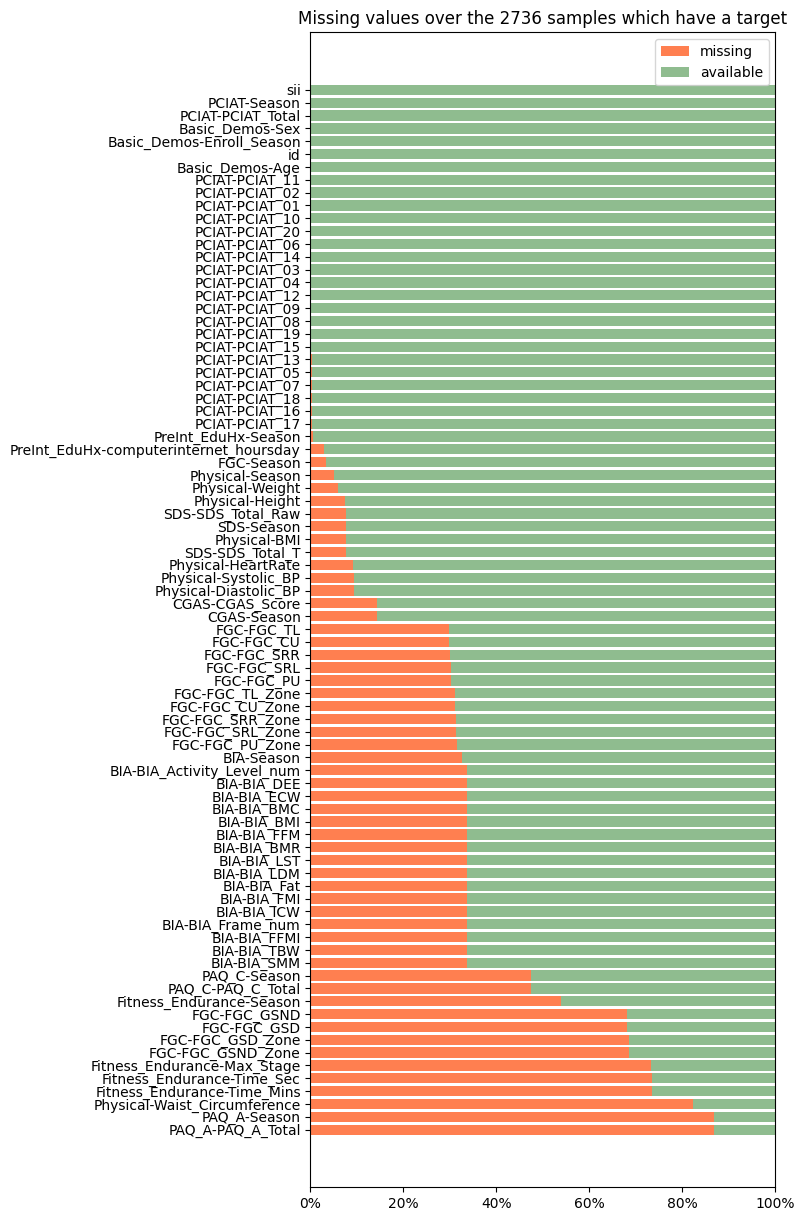

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 'sii' 열이 비어있지 않은 데이터만 포함
supervised_usable = train[train['sii'].notnull()]

# 각 열의 null값 개수와 비율 포함, null값이 많은 순서대로 정렬
missing_count = (
    supervised_usable.isnull().sum()
    .reset_index()
    .rename(columns={'index': 'feature', 0: 'null_count'})
    .sort_values(by='null_count', ascending=False)
)
missing_count['null_ratio'] = missing_count['null_count'] / len(supervised_usable)

# 시각화
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count['null_ratio'], color='coral', label='missing')
plt.barh(np.arange(len(missing_count)),
         1 - missing_count['null_ratio'],
         left=missing_count['null_ratio'],
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count['feature'])
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

In [6]:
# 'sii' 열이 비어있지 않은 데이터만 포함하도록 train을 업데이트
train = train[train['sii'].notnull()]
train.reset_index(inplace = True, drop = True)
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,25.0,60.0,65.0,112.0,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,Fall,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,NaN,NaN,Fal

In [7]:
#train에는 있고 test에는 없는 열 출력
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


In [8]:
# 삭제할 열 목록 정의
columns_to_drop = [
    'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 
    'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 
    'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 
    'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 
    'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 
    'PCIAT-PCIAT_20'
]

# 지정된 열 삭제
train.drop(columns=columns_to_drop, inplace=True)

In [9]:
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,Spring,4.110,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,25.0,60.0,65.0,112.0,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,Fall,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,NaN,NaN,Fall,3.440,22.0,Fall,41.0,58.0,Fall,2.0,0.0
2732,ff759544,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,23.0,65.0,75.0,105.0,NaN,NaN,NaN,NaN,Summer,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,9.0,0.0,8.5,0.0,4.5,0.0,Fall,1.0,2.36680,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.41470,1.0,20.0572,15.14000,42.8185,18.0937,30.0453,NaN,NaN,NaN,NaN,33.0,Summer,48.0,67.0,Summer,0.0,1.0
2733,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,Fall,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.301380,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,Winter,3.260,32.0,Winter,35.0,50.0,Fall,1.0,1.0
2734,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,NaN,79.0,99.0,116.0,NaN,NaN,NaN,

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    floa

In [11]:
# 각 열의 결측값 개수 계산
missing_count = train.isnull().sum()

# 결측값 개수가 1000개 이하인 열을 제거
columns_to_keep = missing_count[missing_count < 1000].index
train = train[columns_to_keep]
train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,Fall,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,75.0,70.0,122.0,Fall,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,65.0,94.0,117.0,Fall,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,60.0,97.0,117.0,Summer,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,60.0,73.0,102.0,Summer,12.0,0.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,60.0,65.0,112.0,Fall,0.0,0.0,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,Fall,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,22.0,Fall,41.0,58.0,Fall,2.0,0.0
2732,ff759544,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,65.0,75.0,105.0,Summer,0.0,0.0,0.0,0.0,9.0,0.0,8.5,0.0,4.5,0.0,Fall,1.0,2.36680,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.41470,1.0,20.0572,15.14000,42.8185,18.0937,30.0453,33.0,Summer,48.0,67.0,Summer,0.0,1.0
2733,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,71.0,70.0,104.0,Fall,16.0,0.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,Fall,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.301380,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,32.0,Winter,35.0,50.0,Fall,1.0,1.0
2734,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,79.0,99.0,116.0,Winter,15.0,1.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,Winter,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.639520,33.99670,2.0,33.9805,21.34030,71.3903,28.7792,54.4630,31.0,Winter,56.0,77.0,Fall,0.0,1.0


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 48 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Diastolic_BP                   2478 non-null   floa

In [13]:
train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PCIAT-PCIAT_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday', 'sii'],
      dtype='object')

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
Physical-Systolic_BP                      0.147081
FGC-FGC_CU                                0.287494
FGC-FGC_PU                                0.196006
FGC-FGC_SRL_Zone                         -0.148850
FGC-FGC_SRR_Zone                         -0.109682
FGC-FGC_TL                                0.136696
BIA-BIA_BMI                               0.248060
BIA-BIA_FFMI                              0.109694
BIA-BIA_Frame_num                         0.193631
SDS-SDS_Total_Raw                         0.234432
SDS-SDS_Total_T                           0.237718
PreInt_EduHx-computerinternet_hoursday    0.374124
Name: PCIAT-PCIAT_Total, dtype: float64


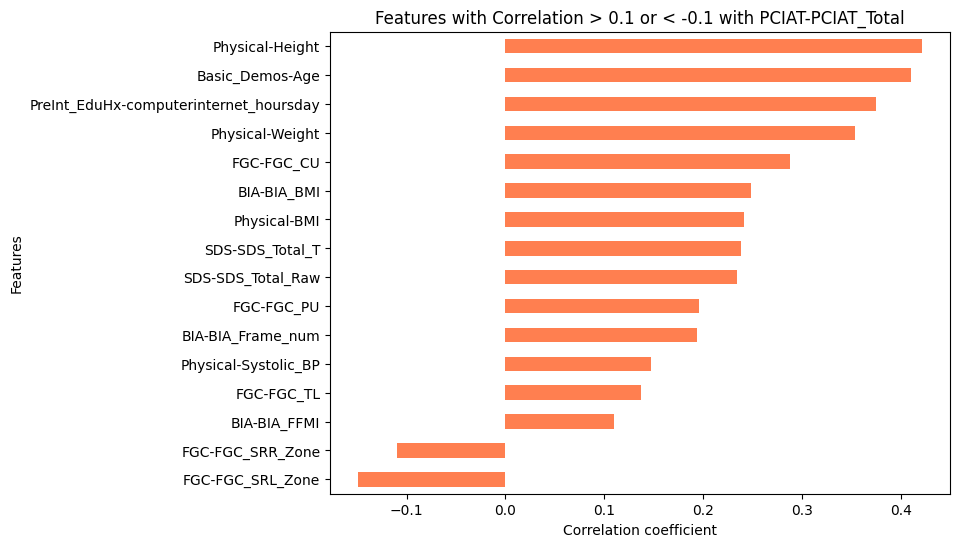

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 'PCIAT-PCIAT_Total'과 다른 열 간의 상관관계 계산
columns_to_select = [
    'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
    'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP',
    'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season',
    'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
    'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
    'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
    'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
    'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
    'BIA-BIA_TBW', 'PCIAT-PCIAT_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
    'PreInt_EduHx-computerinternet_hoursday'
]

# 숫자형 데이터만 선택
numeric_columns = train[columns_to_select].select_dtypes(include=['number'])

# 상관계수 계산
corr_matrix = numeric_columns.corr()

# 'PCIAT-PCIAT_Total'과의 상관관계 추출
sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')

# 상관계수의 절대값이 0.1 이상인 열만 필터링
filtered_corr = sii_corr[(sii_corr.abs() > 0.1)]

# 상관관계 출력
print(filtered_corr)

# 상관관계 시각화
plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()


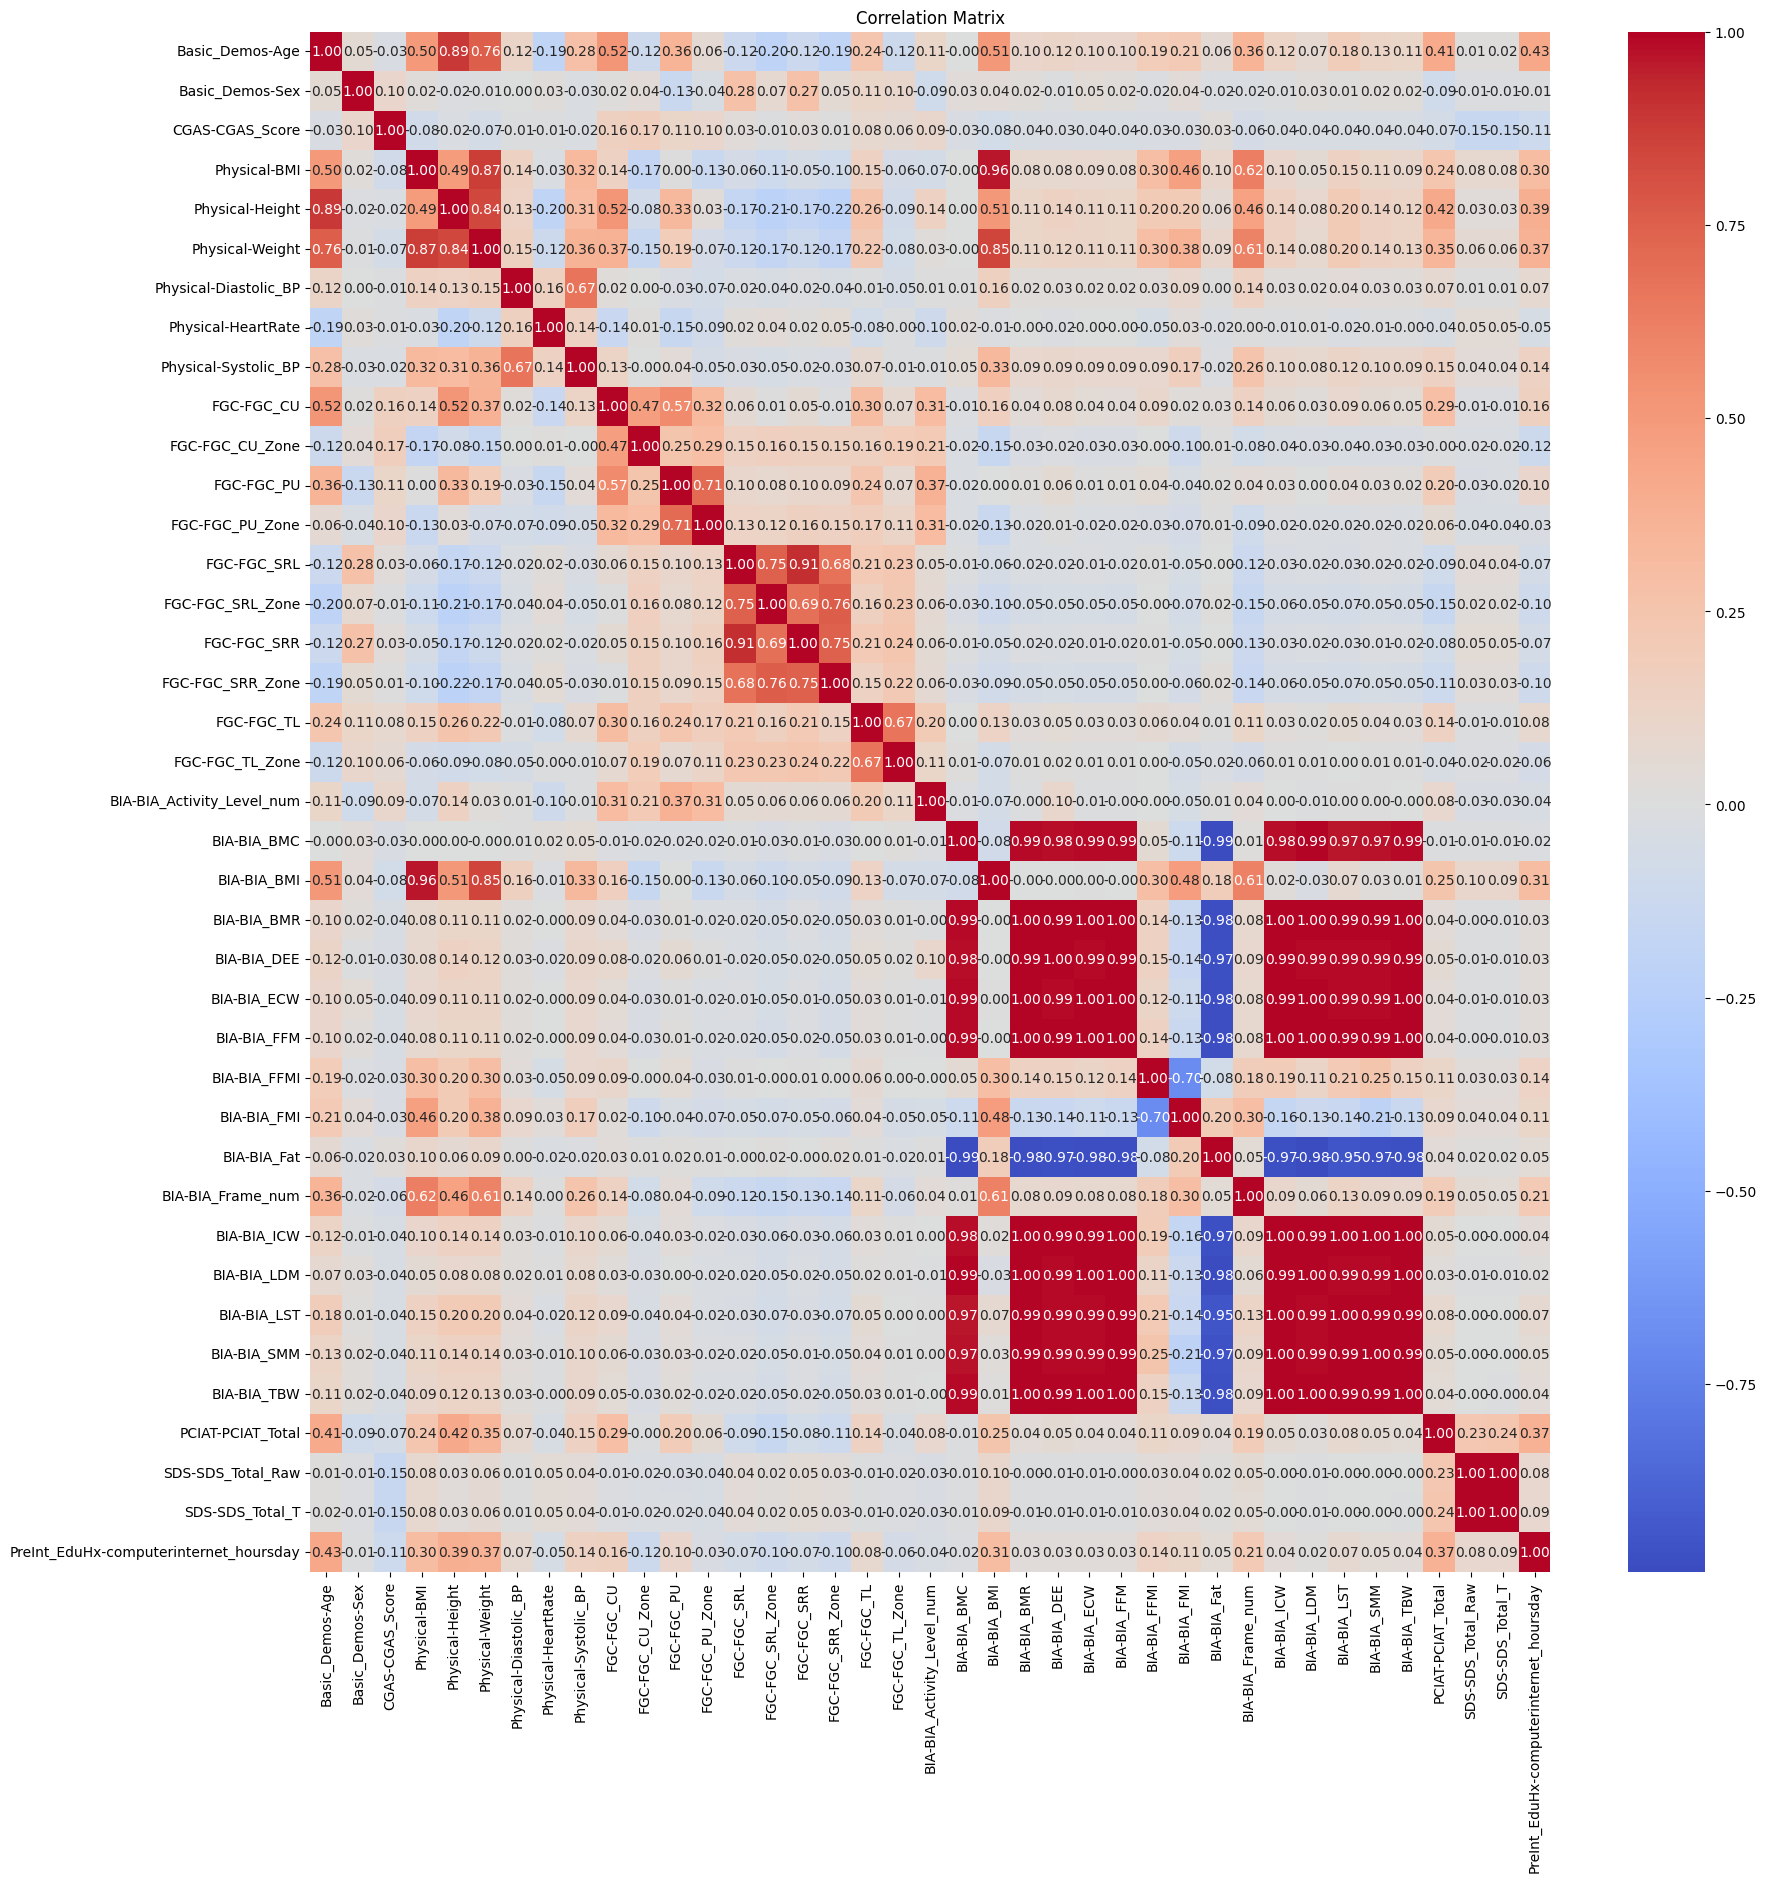

In [15]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [16]:
# 파생변수

train['BMI_Age'] = train['Physical-BMI'] * train['Basic_Demos-Age']
train['Internet_Hours_Age'] = train['PreInt_EduHx-computerinternet_hoursday'] * train['Basic_Demos-Age']
train['BMI_Internet_Hours'] = train['Physical-BMI'] * train['PreInt_EduHx-computerinternet_hoursday']
train['FMI_BFP'] = train['BIA-BIA_FMI'] / train['BIA-BIA_Fat']
train['FGC-FGC-SR'] = (train['FGC-FGC_SRL']+train['FGC-FGC_SRR']) / 2

test['BMI_Age'] = test['Physical-BMI'] * test['Basic_Demos-Age']
test['Internet_Hours_Age'] = test['PreInt_EduHx-computerinternet_hoursday'] * test['Basic_Demos-Age']
test['BMI_Internet_Hours'] = test['Physical-BMI'] * test['PreInt_EduHx-computerinternet_hoursday']
test['FMI_BFP'] = test['BIA-BIA_FMI'] / test['BIA-BIA_Fat']
test['FGC-FGC-SR'] = (test['FGC-FGC_SRL']+test['FGC-FGC_SRR']) / 2

#사용하는 피처 
features=['Basic_Demos-Enroll_Season','Basic_Demos-Age','Physical-Height','Physical-Weight','Physical-Systolic_BP','Basic_Demos-Sex','CGAS-Season','CGAS-CGAS_Score','Physical-Season','Physical-BMI','Physical-Diastolic_BP','Physical-HeartRate','FGC-FGC_CU','FGC-FGC_PU','FGC-FGC_TL','BIA-Season','BIA-BIA_Activity_Level_num',
'BIA-BIA_BMC', 'PreInt_EduHx-computerinternet_hoursday', 'PreInt_EduHx-Season', 'SDS-SDS_Total_T', 'SDS-SDS_Total_Raw','SDS-Season', 'BIA-BIA_Frame_num', 'BIA-BIA_FMI','BIA-BIA_FFMI','BMI_Age', 'Internet_Hours_Age', 'BMI_Internet_Hours', 'FMI_BFP', 'FGC-FGC-SR']


## 3. 데이터 분할

In [17]:
X_train = train[features]# 학습용 데이터
y_train = train['PCIAT-PCIAT_Total']

# 테스트용 데이터
X_test = test[features]  # test 데이터에서 동일한 피처 사용

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               2736 non-null   object 
 1   Basic_Demos-Age                         2736 non-null   int64  
 2   Physical-Height                         2530 non-null   float64
 3   Physical-Weight                         2572 non-null   float64
 4   Physical-Systolic_BP                    2478 non-null   float64
 5   Basic_Demos-Sex                         2736 non-null   int64  
 6   CGAS-Season                             2342 non-null   object 
 7   CGAS-CGAS_Score                         2342 non-null   float64
 8   Physical-Season                         2595 non-null   object 
 9   Physical-BMI                            2527 non-null   float64
 10  Physical-Diastolic_BP                   2478 non-null   floa

In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               20 non-null     object 
 1   Basic_Demos-Age                         20 non-null     int64  
 2   Physical-Height                         13 non-null     float64
 3   Physical-Weight                         13 non-null     float64
 4   Physical-Systolic_BP                    11 non-null     float64
 5   Basic_Demos-Sex                         20 non-null     int64  
 6   CGAS-Season                             10 non-null     object 
 7   CGAS-CGAS_Score                         8 non-null      float64
 8   Physical-Season                         14 non-null     object 
 9   Physical-BMI                            13 non-null     float64
 10  Physical-Diastolic_BP                   11 non-null     float64


결측값 처리

In [20]:

# 범주형 데이터: 최빈값으로 대체
categorical_features = X_train.select_dtypes(include=['object']).columns
for feature in categorical_features:
    X_train[feature].fillna(X_train[feature].mode()[0], inplace=True)

# 범주형 데이터: 최빈값으로 대체
categorical_features = X_test.select_dtypes(include=['object']).columns
for feature in categorical_features:
    X_test[feature].fillna(X_test[feature].mode()[0], inplace=True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               2736 non-null   object 
 1   Basic_Demos-Age                         2736 non-null   int64  
 2   Physical-Height                         2530 non-null   float64
 3   Physical-Weight                         2572 non-null   float64
 4   Physical-Systolic_BP                    2478 non-null   float64
 5   Basic_Demos-Sex                         2736 non-null   int64  
 6   CGAS-Season                             2736 non-null   object 
 7   CGAS-CGAS_Score                         2342 non-null   float64
 8   Physical-Season                         2736 non-null   object 
 9   Physical-BMI                            2527 non-null   float64
 10  Physical-Diastolic_BP                   2478 non-null   floa

In [21]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               20 non-null     object 
 1   Basic_Demos-Age                         20 non-null     int64  
 2   Physical-Height                         13 non-null     float64
 3   Physical-Weight                         13 non-null     float64
 4   Physical-Systolic_BP                    11 non-null     float64
 5   Basic_Demos-Sex                         20 non-null     int64  
 6   CGAS-Season                             20 non-null     object 
 7   CGAS-CGAS_Score                         8 non-null      float64
 8   Physical-Season                         20 non-null     object 
 9   Physical-BMI                            13 non-null     float64
 10  Physical-Diastolic_BP                   11 non-null     float64


In [22]:
X_train.isnull().sum()

Basic_Demos-Enroll_Season                   0
Basic_Demos-Age                             0
Physical-Height                           206
Physical-Weight                           164
Physical-Systolic_BP                      258
Basic_Demos-Sex                             0
CGAS-Season                                 0
CGAS-CGAS_Score                           394
Physical-Season                             0
Physical-BMI                              209
Physical-Diastolic_BP                     258
Physical-HeartRate                        250
FGC-FGC_CU                                817
FGC-FGC_PU                                827
FGC-FGC_TL                                817
BIA-Season                                  0
BIA-BIA_Activity_Level_num                923
BIA-BIA_BMC                               923
PreInt_EduHx-computerinternet_hoursday     82
PreInt_EduHx-Season                         0
SDS-SDS_Total_T                           211
SDS-SDS_Total_Raw                 

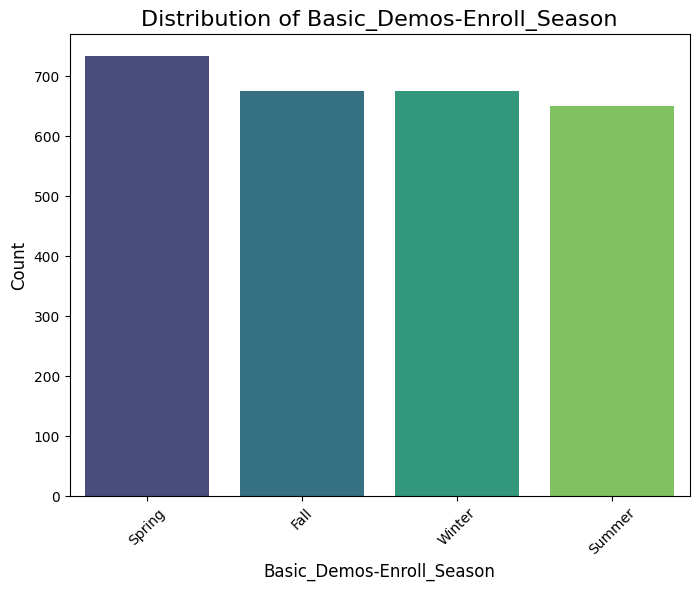

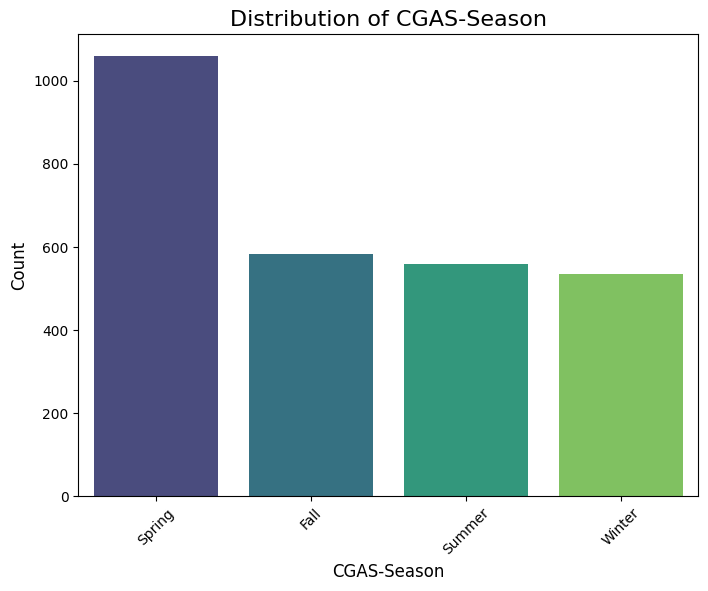

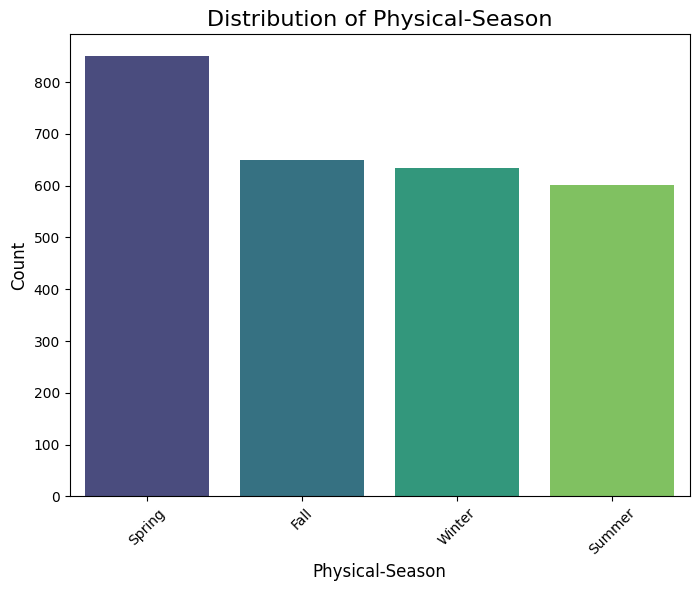

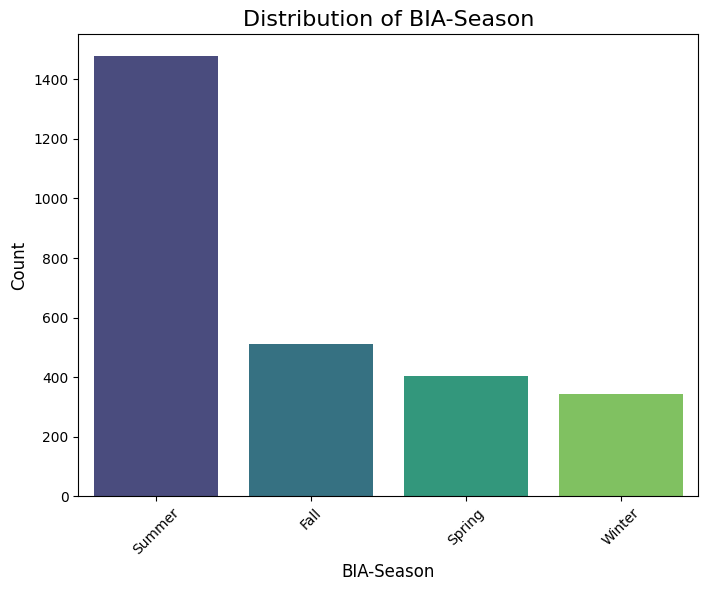

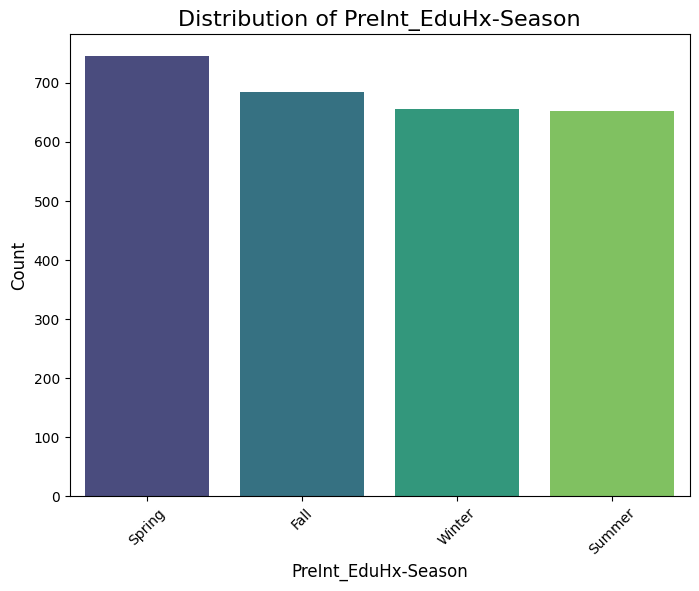

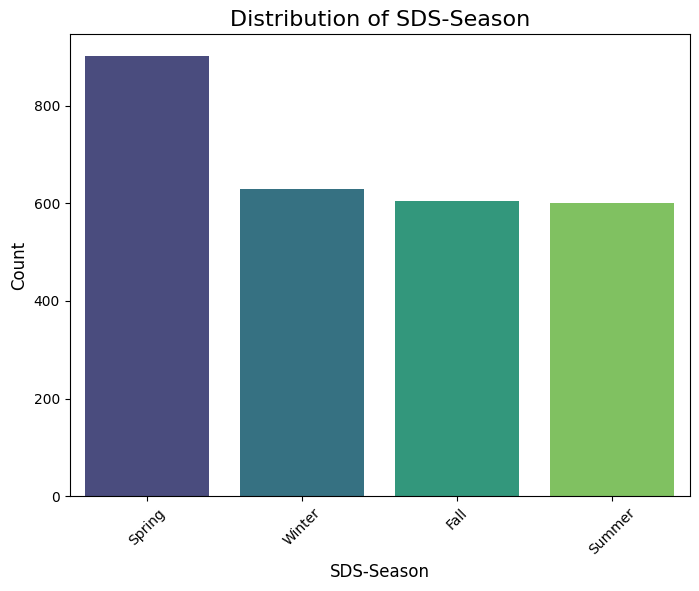

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 범주형 데이터 선택
categorical_features = X_train.select_dtypes(include=['object']).columns

# 각 범주형 데이터에 대해 그래프 그리기
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    value_counts = X_train[feature].value_counts()  # 각 범주의 값과 빈도
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)  # 필요 시 글자 회전
    plt.show()

In [24]:
from sklearn.preprocessing import LabelEncoder

# 범주형 열 찾기
categorical_features = X_train.select_dtypes(include=['object']).columns

# Label Encoding 적용
le = LabelEncoder()
for feature in categorical_features:
    X_train[feature] = le.fit_transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])

In [25]:
X_train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Physical-Height,Physical-Weight,Physical-Systolic_BP,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_TL,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,PreInt_EduHx-computerinternet_hoursday,PreInt_EduHx-Season,SDS-SDS_Total_T,SDS-SDS_Total_Raw,SDS-Season,BIA-BIA_Frame_num,BIA-BIA_FMI,BIA-BIA_FFMI,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,FMI_BFP,FGC-FGC-SR
0,0,5,46.0,50.8,NaN,0,3,51.0,0,16.877316,NaN,NaN,0.0,0.0,6.0,0,2.0,2.66855,3.0,0,NaN,NaN,1,1.0,3.061430,13.8177,84.386578,15.0,50.631947,0.332267,6.50
1,2,9,48.0,46.0,122.0,0,1,NaN,0,14.035590,75.0,70.0,3.0,5.0,3.0,3,2.0,2.57949,0.0,2,64.0,46.0,0,1.0,1.211720,12.8254,126.320313,0.0,0.000000,0.305154,11.00
2,2,10,56.5,75.6,117.0,1,0,71.0,0,16.648696,65.0,94.0,20.0,7.0,5.0,2,NaN,NaN,2.0,2,54.0,38.0,0,NaN,NaN,NaN,166.486961,20.0,33.297392,NaN,10.00
3,3,9,56.0,81.6,117.0,0,0,71.0,2,18.292347,60.0,97.0,18.0,5.0,7.0,2,3.0,3.84191,0.0,3,45.0,31.0,2,2.0,4.220330,14.0740,164.631122,0.0,0.000000,0.224196,7.00
4,1,13,59.5,112.2,102.0,1,3,50.0,2,22.279952,60.0,73.0,12.0,6.0,8.0,2,2.0,4.33036,0.0,1,56.0,40.0,2,2.0,13.498800,16.6877,289.639376,0.0,0.000000,0.198595,10.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,0,8,52.5,67.2,112.0,0,1,NaN,0,17.139810,60.0,65.0,0.0,0.0,12.0,0,3.0,3.20303,2.0,0,58.0,41.0,0,1.0,3.741300,13.4004,137.118476,16.0,34.279619,0.255085,9.00
2732,2,7,48.5,46.6,105.0,1,1,NaN,2,13.927006,65.0,75.0,0.0,0.0,4.5,0,1.0,2.36680,0.0,2,67.0,48.0,2,1.0,0.414263,13.2315,97.489042,0.0,0.000000,0.292827,8.75
2733,0,13,59.5,82.4,104.0,0,1,60.0,0,16.362460,71.0,70.0,16.0,10.0,12.0,0,3.0,4.52277,1.0,0,50.0,35.0,3,1.0,2.301380,14.0629,212.711984,13.0,16.362460,0.198595,8.50
2734,0,11,60.0,109.8,116.0,0,1,68.0,3,21.441500,79.0,99.0,15.0,0.0,14.0,3,2.0,4.41305,0.0,0,77.0,56.0,3,2.0,6.639520,14.8043,235.856500,0.0,0.000000,0.195299,10.00


In [26]:
from sklearn.linear_model import LinearRegression

# 숫자형 데이터만 선택
numeric_columns = X_train.select_dtypes(include=['number']).columns

# 결측치가 있는 컬럼에 대해 회귀 방법으로 결측치 채우기
for column in numeric_columns:
    if X_train[column].isnull().sum() > 0:
        # 결측치가 없는 데이터만 사용
        train_data = X_train[X_train[column].notnull()][numeric_columns]
        test_data = X_train[X_train[column].isnull()][numeric_columns]
        
        # 예측하려는 피처를 제외한 나머지 데이터를 독립 변수로 사용
        X_train_p = train_data.drop(columns=[column])
        y_train_p = train_data[column]
        X_test_p  = test_data.drop(columns=[column])
        
        # 숫자로 변환 및 결측값 처리
        X_train_p = X_train_p.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_test_p = X_test_p.apply(pd.to_numeric, errors='coerce').fillna(0)
        y_train_p = y_train_p.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        # 모델 학습
        model = LinearRegression()
        model.fit(X_train_p, y_train_p)
        
        # 결측치 예측
        predicted_values = model.predict(X_test_p)
        
        # 예측된 값을 원본 데이터에 채우기
        X_train.loc[X_train[column].isnull(), column] = predicted_values

# 결측치 확인
print(X_train.isnull().sum())

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Physical-Height                           0
Physical-Weight                           0
Physical-Systolic_BP                      0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
FGC-FGC_CU                                0
FGC-FGC_PU                                0
FGC-FGC_TL                                0
BIA-Season                                0
BIA-BIA_Activity_Level_num                0
BIA-BIA_BMC                               0
PreInt_EduHx-computerinternet_hoursday    0
PreInt_EduHx-Season                       0
SDS-SDS_Total_T                           0
SDS-SDS_Total_Raw                         0
SDS-Season                      

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 31 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Enroll_Season               2736 non-null   int64  
 1   Basic_Demos-Age                         2736 non-null   int64  
 2   Physical-Height                         2736 non-null   float64
 3   Physical-Weight                         2736 non-null   float64
 4   Physical-Systolic_BP                    2736 non-null   float64
 5   Basic_Demos-Sex                         2736 non-null   int64  
 6   CGAS-Season                             2736 non-null   int64  
 7   CGAS-CGAS_Score                         2736 non-null   float64
 8   Physical-Season                         2736 non-null   int64  
 9   Physical-BMI                            2736 non-null   float64
 10  Physical-Diastolic_BP                   2736 non-null   floa

In [28]:
from sklearn.linear_model import LinearRegression

# 숫자형 데이터만 선택
numeric_columns = X_test.select_dtypes(include=['number']).columns

# 결측치가 있는 컬럼에 대해 회귀 방법으로 결측치 채우기
for column in numeric_columns:
    if X_test[column].isnull().sum() > 0:
        # 결측치가 없는 데이터만 사용
        train_data = X_test[X_test[column].notnull()][numeric_columns]
        test_data = X_test[X_test[column].isnull()][numeric_columns]
        
        # 예측하려는 피처를 제외한 나머지 데이터를 독립 변수로 사용
        X_train_p = train_data.drop(columns=[column])
        y_train_p = train_data[column]
        X_test_p  = test_data.drop(columns=[column])
        
        # 숫자로 변환 및 결측값 처리
        X_train_p = X_train_p.apply(pd.to_numeric, errors='coerce').fillna(0)
        X_test_p = X_test_p.apply(pd.to_numeric, errors='coerce').fillna(0)
        y_train_p = y_train_p.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        # 모델 학습
        model = LinearRegression()
        model.fit(X_train_p, y_train_p)
        
        # 결측치 예측
        predicted_values = model.predict(X_test_p)
        
        # 예측된 값을 원본 데이터에 채우기
        X_test.loc[X_test[column].isnull(), column] = predicted_values

# 결측치 확인
print(X_test.isnull().sum())

Basic_Demos-Enroll_Season                 0
Basic_Demos-Age                           0
Physical-Height                           0
Physical-Weight                           0
Physical-Systolic_BP                      0
Basic_Demos-Sex                           0
CGAS-Season                               0
CGAS-CGAS_Score                           0
Physical-Season                           0
Physical-BMI                              0
Physical-Diastolic_BP                     0
Physical-HeartRate                        0
FGC-FGC_CU                                0
FGC-FGC_PU                                0
FGC-FGC_TL                                0
BIA-Season                                0
BIA-BIA_Activity_Level_num                0
BIA-BIA_BMC                               0
PreInt_EduHx-computerinternet_hoursday    0
PreInt_EduHx-Season                       0
SDS-SDS_Total_T                           0
SDS-SDS_Total_Raw                         0
SDS-Season                      

In [29]:
X_test

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Physical-Height,Physical-Weight,Physical-Systolic_BP,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_TL,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,PreInt_EduHx-computerinternet_hoursday,PreInt_EduHx-Season,SDS-SDS_Total_T,SDS-SDS_Total_Raw,SDS-Season,BIA-BIA_Frame_num,BIA-BIA_FMI,BIA-BIA_FFMI,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,FMI_BFP,FGC-FGC-SR
0,0,5,46.000000,50.800000,64.002438,0,3,51.000000,0,16.877316,90.150449,80.117043,0.000000,0.000000,6.000000,0,2.000000,2.668550,3.000000,0,18.394020,14.999507,0,1.000000,3.061430,13.817700,84.386578,15.000000,50.631947,0.332267,6.500000
1,2,9,48.000000,46.000000,122.000000,0,2,78.583935,0,14.035590,75.000000,70.000000,3.000000,5.000000,3.000000,3,2.000000,2.579490,0.000000,2,64.000000,46.000000,0,1.000000,1.211720,12.825400,126.320313,0.000000,0.000000,0.305154,11.000000
2,2,10,56.500000,75.600000,117.000000,1,0,71.000000,0,16.648696,65.000000,94.000000,20.000000,7.000000,5.000000,0,2.918557,3.533179,2.000000,2,54.000000,38.000000,0,1.651473,3.015423,13.992647,166.486961,20.000000,33.297392,0.249809,10.000000
3,3,9,56.000000,81.600000,117.000000,0,0,71.000000,2,18.292347,60.000000,97.000000,18.000000,5.000000,7.000000,2,3.000000,3.841910,0.000000,3,45.000000,31.000000,2,2.000000,4.220330,14.074000,164.631122,0.000000,0.000000,0.224196,7.000000
4,1,18,49.783357,-27.146526,50.252987,1,2,70.200223,0,-0.705202,71.215306,75.456773,3.845453,2.328879,-6.571148,0,3.329737,1.783850,1.046318,0,24.406064,21.868913,0,-0.026801,-5.971926,11.008732,94.350765,17.185834,4.910846,0.387375,3.802585
5,1,13,59.500000,112.200000,102.000000,1,3,50.000000,2,22.279952,60.000000,73.000000,12.000000,6.000000,8.000000,2,2.000000,4.330360,0.000000,1,56.000000,40.000000,2,2.000000,13.498800,16.687700,289.639376,0.000000,0.000000,0.198595,10.500000
6,0,10,55.000000,84.600000,163.000000,0,2,84.195592,0,19.660760,123.000000,83.000000,9.000000,2.000000,11.000000,0,2.000000,3.782710,3.000000,0,40.000000,27.000000,3,2.000000,4.962910,14.700000,196.607603,30.000000,58.982281,0.232422,11.000000
7,0,10,59.250000,84.200000,116.000000,1,2,76.642021,0,16.861286,71.000000,90.000000,0.000000,0.000000,4.000000,0,3.000000,4.057260,2.000000,0,20.986750,17.611882,0,2.000000,3.253950,13.609200,168.612865,20.000000,33.722573,0.200275,0.000000
8,2,15,51.998495,-1.471437,88.994001,0,2,80.587827,1,-4.500189,92.574928,83.480716,5.249209,0.864191,-2.566151,0,3.146453,2.266034,2.000000,2,20.343768,16.610099,0,0.692437,-6.097700,10.976732,56.004889,30.000000,31.481242,0.355530,3.971735
9,2,19,50.087021,-27.204459,49.036013,1,2,69.702329,0,-1.024159,71.657592,75.259907,4.190524,2.229298,-7.004155,0,3.291244,1.772094,0.993993,0,24.697527,22.227275,0,-0.034241,-5.809175,11.042919,99.908125,17.618516,5.911918,0.386913,3.804543


In [30]:
X_train

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Physical-Height,Physical-Weight,Physical-Systolic_BP,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_TL,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,PreInt_EduHx-computerinternet_hoursday,PreInt_EduHx-Season,SDS-SDS_Total_T,SDS-SDS_Total_Raw,SDS-Season,BIA-BIA_Frame_num,BIA-BIA_FMI,BIA-BIA_FFMI,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,FMI_BFP,FGC-FGC-SR
0,0,5,46.0,50.8,54.194776,0,3,51.000000,0,16.877316,33.95295,78.059104,0.0000,0.000000,6.000000,0,2.000000,2.668550,3.0,0,5.663931,0.228638,1,1.000000,3.061430,13.817700,84.386578,15.0,50.631947,0.332267,6.500000
1,2,9,48.0,46.0,122.000000,0,1,63.192088,0,14.035590,75.00000,70.000000,3.0000,5.000000,3.000000,3,2.000000,2.579490,0.0,2,64.000000,46.000000,0,1.000000,1.211720,12.825400,126.320313,0.0,0.000000,0.305154,11.000000
2,2,10,56.5,75.6,117.000000,1,0,71.000000,0,16.648696,65.00000,94.000000,20.0000,7.000000,5.000000,2,2.827154,549.671907,2.0,2,54.000000,38.000000,0,1.179568,6.020027,0.631391,166.486961,20.0,33.297392,0.159886,10.000000
3,3,9,56.0,81.6,117.000000,0,0,71.000000,2,18.292347,60.00000,97.000000,18.0000,5.000000,7.000000,2,3.000000,3.841910,0.0,3,45.000000,31.000000,2,2.000000,4.220330,14.074000,164.631122,0.0,0.000000,0.224196,7.000000
4,1,13,59.5,112.2,102.000000,1,3,50.000000,2,22.279952,60.00000,73.000000,12.0000,6.000000,8.000000,2,2.000000,4.330360,0.0,1,56.000000,40.000000,2,2.000000,13.498800,16.687700,289.639376,0.0,0.000000,0.198595,10.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,0,8,52.5,67.2,112.000000,0,1,61.717445,0,17.139810,60.00000,65.000000,0.0000,0.000000,12.000000,0,3.000000,3.203030,2.0,0,58.000000,41.000000,0,1.000000,3.741300,13.400400,137.118476,16.0,34.279619,0.255085,9.000000
2732,2,7,48.5,46.6,105.000000,1,1,65.213322,2,13.927006,65.00000,75.000000,0.0000,0.000000,4.500000,0,1.000000,2.366800,0.0,2,67.000000,48.000000,2,1.000000,0.414263,13.231500,97.489042,0.0,0.000000,0.292827,8.750000
2733,0,13,59.5,82.4,104.000000,0,1,60.000000,0,16.362460,71.00000,70.000000,16.0000,10.000000,12.000000,0,3.000000,4.522770,1.0,0,50.000000,35.000000,3,1.000000,2.301380,14.062900,212.711984,13.0,16.362460,0.198595,8.500000
2734,0,11,60.0,109.8,116.000000,0,1,68.000000,3,21.441500,79.00000,99.000000,15.0000,0.000000,14.000000,3,2.000000,4.413050,0.0,0,77.000000,56.000000,3,2.000000,6.639520,14.804300,235.856500,0.0,0.000000,0.195299,10.000000


In [31]:
y_train

0       55.0
1        0.0
2       28.0
3       44.0
4       34.0
        ... 
2731    22.0
2732    33.0
2733    32.0
2734    31.0
2735    19.0
Name: PCIAT-PCIAT_Total, Length: 2736, dtype: float64

## 4. 검증데이터 생성

In [32]:
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_train,  # 피처
    y_train,  # 타겟
    test_size=0.2,  # 20%를 검증 데이터로
    random_state=42  # 재현성을 위해 난수 고정
)


In [33]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
voting_regressor = VotingRegressor(estimators=[
    ("xgb", XGBRegressor(n_estimators= 137, max_depth= 4, learning_rate= 0.10567854073293201, subsample= 0.39344347297910576, random_state=0)),
    #("lr", LinearRegression())
])

# Create the final pipeline
model = Pipeline(steps=[("model", voting_regressor)])

# Fit the model
model.fit(X_train, y_train)
# Perform cross-validation

Pipeline(steps=[('model',
                 VotingRegressor(estimators=[('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.10567854073293201,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=4,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=137,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=0, ...))]))])

In [34]:
#model = RandomForestRegressor(random_state=42)
#model.fit(X_train, y_train)

In [35]:
y_val_pred = model.predict(X_val)


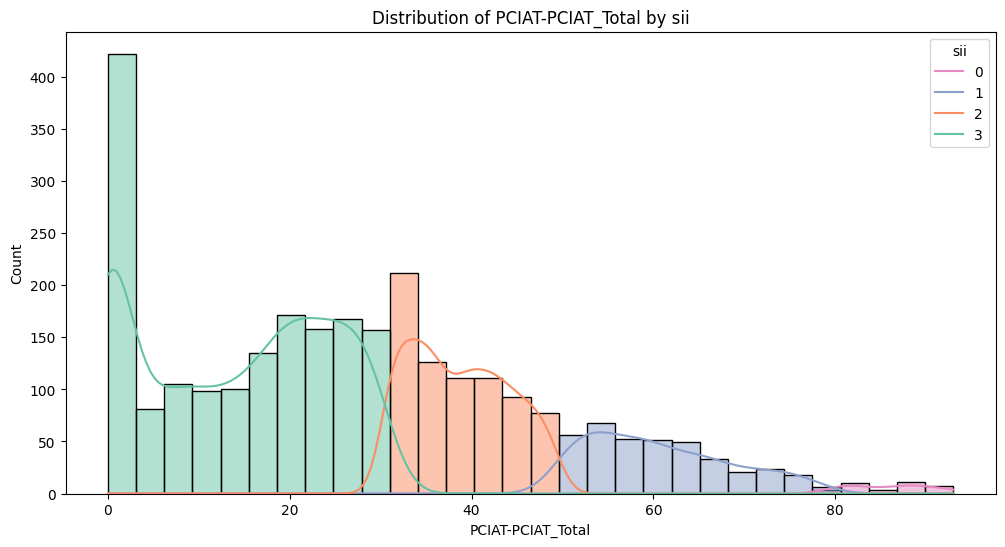

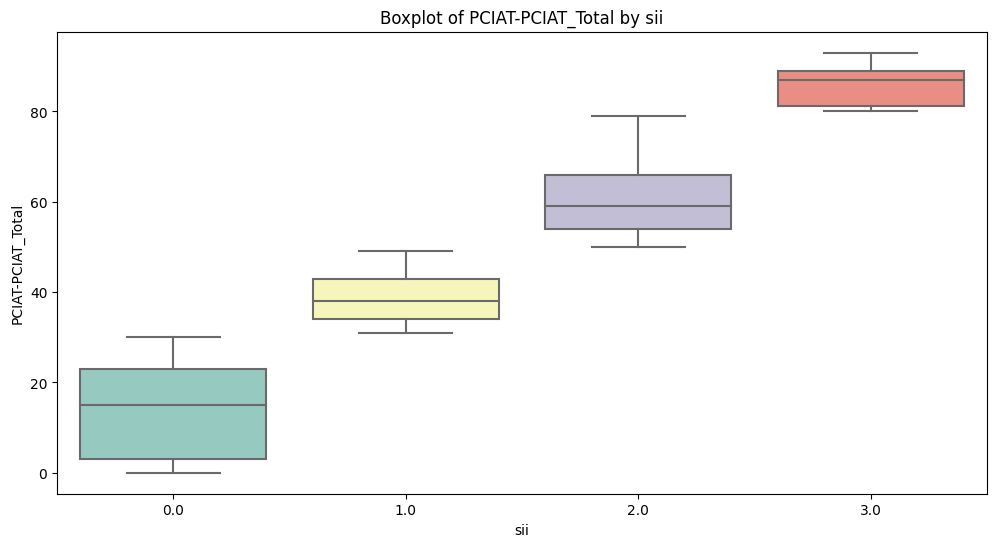

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 'PCIAT-PCIAT_Total' 값에 따라 'sii' 분포를 히스토그램으로 시각화
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='PCIAT-PCIAT_Total', hue='sii', kde=True, bins=30, palette='Set2')
plt.title('Distribution of PCIAT-PCIAT_Total by sii')
plt.xlabel('PCIAT-PCIAT_Total')
plt.ylabel('Count')
plt.legend(title='sii', labels=['0', '1', '2', '3'])
plt.show()

# 2. 'PCIAT-PCIAT_Total'과 'sii' 관계를 Boxplot으로 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='sii', y='PCIAT-PCIAT_Total', palette='Set3')
plt.title('Boxplot of PCIAT-PCIAT_Total by sii')
plt.xlabel('sii')
plt.ylabel('PCIAT-PCIAT_Total')
plt.show()

In [37]:
# 'PCIAT-PCIAT_Total' 값에 따른 'sii'별 통계량 계산
sii_stats = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max', 'mean', 'median']).reset_index()

# 결과 출력
print(sii_stats)

   sii   min   max       mean  median
0  0.0   0.0  30.0  13.929737    15.0
1  1.0  31.0  49.0  38.726027    38.0
2  2.0  50.0  79.0  60.658730    59.0
3  3.0  80.0  93.0  85.911765    87.0


In [38]:
def classify_sii(predicted_value):
    if predicted_value < 30:
        return 0
    elif 30 <= predicted_value < 50:
        return 1
    elif 50 <= predicted_value < 80:
        return 2
    else:
        return 3

# 분류 생성
y_val_sii = [classify_sii(value) for value in y_val_pred]
y_val_actual_sii = [classify_sii(value) for value in y_val]


In [39]:
#검증 score 확인하는 부분인데 좀 이상해요..

from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score

# Quadratic Weighted Kappa
kappa_score = cohen_kappa_score(y_val_actual_sii, y_val_sii, weights="quadratic")
print("Quadratic Weighted Kappa:", kappa_score)

# 분류 정확도
acc = accuracy_score(y_val_actual_sii, y_val_sii)
print("Accuracy:", acc)

# 혼동 행렬
cm = confusion_matrix(y_val_actual_sii, y_val_sii)
print("Confusion Matrix:\n", cm)


Quadratic Weighted Kappa: 0.4038165256642431
Accuracy: 0.5656934306569343
Confusion Matrix:
 [[243  81   8   0]
 [ 69  55  11   0]
 [ 13  47  12   0]
 [  0   7   2   0]]


In [40]:
# 테스트 데이터 예측
test['Predicted_PCIAT_Total'] = model.predict(X_test)

# 예측 결과 출력
print(test[['Predicted_PCIAT_Total']].head())

   Predicted_PCIAT_Total
0              18.744558
1              10.439417
2              34.994995
3              16.650034
4              25.890888


In [41]:
# 예측값을 기반으로 'sii' 생성
test['sii'] = test['Predicted_PCIAT_Total'].apply(classify_sii)

# 최종 결과 출력
print(test[['Predicted_PCIAT_Total', 'sii']].head())

   Predicted_PCIAT_Total  sii
0              18.744558    0
1              10.439417    0
2              34.994995    1
3              16.650034    0
4              25.890888    0


## 5. 제출 및 서브미션

In [42]:
import pandas as pd

from datetime import datetime

# Load the sample submission file
sample_submission_path = '/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

# test 데이터에 'id'와 'sii'가 있다고 가정
submission = test[['id', 'sii']]


# Define the submission file name with the current date
submission_filename = f"submission.csv"

# Save the submission file
submission.to_csv(submission_filename, index=False)

submission_filename


'submission.csv'

In [43]:
submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,0
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0
